# CV Problem - Image Classification

In [1]:
from pickle import load # to load pickled files
import numpy as np # for data manipulation
import matplotlib.pyplot as plt # for displaying images

In [2]:
# function that loads pickled files and returns the data
def load_data(filename):
    return load(open(filename, 'rb'))

In [3]:
# variables
fn_train_image = "train_image.pkl"
fn_train_label = "train_label.pkl"
fn_test_image = "test_image.pkl"

## Load train images

In [4]:
# load training images
train_images = load_data(fn_train_image)

In [5]:
# find the length of train data
len(train_images)

8000

In [6]:
# create num_images variable
num_images = len(train_images)

In [7]:
# sneak-peak
len(train_images[0])

784

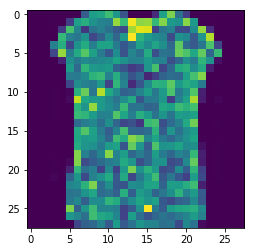

In [8]:
# display an image
plt.imshow(np.array(train_images[8]).reshape((28, 28)))

## Prepare train images

In [9]:
_X_train = []

In [10]:
# convert image array to numpy arrays and reshape them
for i in range(len(train_images)):
    curr_image = train_images[i]
    curr_image_np = np.array(curr_image).reshape(28, 28, 1)
    _X_train.append(curr_image_np)

In [11]:
X_train = np.array(_X_train)
X_train = X_train.astype('float32')
X_train = X_train / 255.0

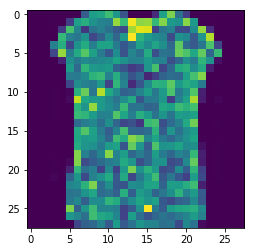

In [12]:
# sneak-peak to check if everything is ok
plt.imshow(X_train[8].reshape(28, 28))

## Load train labels

In [13]:
# load train labels
_train_labels = load_data(fn_train_label)

In [14]:
# assert length
assert len(_train_labels) == num_images

In [15]:
# find number of classes
max_class_id = max(_train_labels)
max_class_id

6

Number of classes present are 7

In [16]:
num_classes = 7

## Find if classes are balanced or not

In [17]:
classes = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}

In [18]:
for label in _train_labels:
    classes[label] += 1
classes

{0: 2000, 1: 0, 2: 2000, 3: 2000, 4: 0, 5: 0, 6: 2000}

Train data contains 2000 images each of classes 0, 2, 3 and 6. Classes 1, 4 and 5 are not present.

## Let's fix this imbalance in this step

In [19]:
num_classes = 4

In [20]:
# create a mapping from new classes to old ones
new_to_old = {0: 0, 1: 2, 2: 3, 3: 6}
old_to_new = {new_to_old[key]: key for key in new_to_old.keys()}

In [21]:
new_to_old, old_to_new

({0: 0, 1: 2, 2: 3, 3: 6}, {0: 0, 2: 1, 3: 2, 6: 3})

In [22]:
train_labels = np.zeros(shape=(len(_train_labels), ))
for i in range(len(_train_labels)):
    train_labels[i] = old_to_new[_train_labels[i]]

In [23]:
# check first values
_train_labels[3200:3220], train_labels[3200:3220]

([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.]))

## Prepare model creation

In [24]:
# we'll use keras for quick prototyping
from tensorflow.keras.utils import to_categorical

In [25]:
# create train labels
y_train = []

In [26]:
for i in range(num_images):
    y_train.append(to_categorical(train_labels[i], num_classes))

In [27]:
y_train = np.array(y_train)
y_train = y_train.astype('float32')
y_train = y_train / 255.0

In [28]:
# confirm y_train shape to be (?, 4)
y_train.shape

(8000, 4)

In [29]:
# imports for shuffling train data since the current data is ordered according to class
from sklearn.utils import shuffle
_X_train_shuffled, _y_train_shuffled = shuffle(X_train, y_train)

In [30]:
# import for splitting data into train and validation
from sklearn.model_selection import train_test_split
X_train_shuffled, X_test, y_train_shuffled, y_test = train_test_split(_X_train_shuffled, _y_train_shuffled, test_size=0.1, random_state=42)

## Data Augmentation

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [32]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train_shuffled)

## Convolution Neural Network Model
We'll implement a Deep CNN Model with regularization techniques

In [33]:
# import keras model modules
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.models import Model

In [34]:
# define the model
x = Input(shape=(28, 28, 1))
conv1 = Conv2D(32, (3,3), padding='same', activation='relu')(x)
conv2 = Conv2D(32, (3,3), padding='same', activation='relu')(conv1)
conv2_maxpool = MaxPooling2D(pool_size=(2,2))(conv2)
conv2_maxpool_dropout = Dropout(0.25)(conv2_maxpool)

conv3 = Conv2D(64, (3,3), padding='same', activation='relu')(conv2_maxpool_dropout)
conv4 = Conv2D(64, (3,3), padding='same', activation='relu')(conv3)
conv4_maxpool = MaxPooling2D(pool_size=(2,2))(conv4)
conv4_maxpool_dropout = Dropout(0.25)(conv4_maxpool)

# conv5 = Conv2D(128, (3,3), padding='same', activation='relu')(conv4_maxpool_dropout)
# conv6 = Conv2D(128, (3,3), padding='same', activation='relu')(conv5)
# conv6_maxpool = MaxPooling2D(pool_size=(2,2))(conv6)
# conv6_maxpool_dropout = Dropout(0.25)(conv6_maxpool)

flatten = Flatten()(conv4_maxpool_dropout)
# fc1 = Dense(512, activation='relu')(flatten)
# fc1_dropout = Dropout(0.5)(fc1)
fc3 = Dense(num_classes, activation='softmax')(flatten)

model = Model(inputs=x, outputs=fc3)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
__________

## Extra Model Configuration

In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint # for saving the best model

In [36]:
# name of the saved weights file
weights_file = "./weights/weights-loss-{val_loss:.4f}-acc-{val_acc:.4f}-epoch-{epoch}.h5"

In [37]:
# saves the model with lowest loss to a weights file
checkpoint = ModelCheckpoint(weights_file, monitor='val_loss', verbose=1, save_weights_only=True)
callbacks_list = [checkpoint]

## Compile Model
Compile the model with
1. loss function as categorical crossentropy
2. optimizer as Adam
3. metric as accuracy

In [38]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Model Hyper-parameters

In [39]:
n_epochs = 200
batch_size = 512

Finally, it's time to train our model

In [40]:
model.fit_generator(datagen.flow(X_train_shuffled, y_train_shuffled, batch_size=batch_size), epochs=n_epochs, verbose=1, steps_per_epoch=X_train_shuffled.shape[0]//batch_size, validation_data=(X_test, y_test), callbacks=callbacks_list)

Epoch 1/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0051 - acc: 0.3863
Epoch 00001: saving model to ./weights/weights-loss-0.0033-acc-0.7050-epoch-1.h5
14/14 [==============================] - 3s 237ms/step - loss: 0.0051 - acc: 0.4024 - val_loss: 0.0033 - val_acc: 0.7050
Epoch 2/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0036 - acc: 0.5971
Epoch 00002: saving model to ./weights/weights-loss-0.0028-acc-0.7113-epoch-2.h5
14/14 [==============================] - 1s 62ms/step - loss: 0.0036 - acc: 0.5992 - val_loss: 0.0028 - val_acc: 0.7113
Epoch 3/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0034 - acc: 0.6468
Epoch 00003: saving model to ./weights/weights-loss-0.0026-acc-0.7225-epoch-3.h5
14/14 [==============================] - 1s 64ms/step - loss: 0.0033 - acc: 0.6476 - val_loss: 0.0026 - val_acc: 0.7225
Epoch 4/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0031 - acc: 0.6675
Epoch 00004: saving model to ./weigh

13/14 [==========================>...] - ETA: 0s - loss: 0.0021 - acc: 0.7915
Epoch 00029: saving model to ./weights/weights-loss-0.0015-acc-0.8500-epoch-29.h5
14/14 [==============================] - 1s 65ms/step - loss: 0.0021 - acc: 0.7937 - val_loss: 0.0015 - val_acc: 0.8500
Epoch 30/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0020 - acc: 0.7987
Epoch 00030: saving model to ./weights/weights-loss-0.0015-acc-0.8650-epoch-30.h5
14/14 [==============================] - 1s 60ms/step - loss: 0.0020 - acc: 0.7996 - val_loss: 0.0015 - val_acc: 0.8650
Epoch 31/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0021 - acc: 0.7916
Epoch 00031: saving model to ./weights/weights-loss-0.0015-acc-0.8650-epoch-31.h5
14/14 [==============================] - 1s 58ms/step - loss: 0.0021 - acc: 0.7912 - val_loss: 0.0015 - val_acc: 0.8650
Epoch 32/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0020 - acc: 0.8029
Epoch 00032: saving model to ./weights/weig

13/14 [==========================>...] - ETA: 0s - loss: 0.0017 - acc: 0.8356
Epoch 00057: saving model to ./weights/weights-loss-0.0012-acc-0.8875-epoch-57.h5
14/14 [==============================] - 1s 63ms/step - loss: 0.0017 - acc: 0.8371 - val_loss: 0.0012 - val_acc: 0.8875
Epoch 58/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0017 - acc: 0.8304
Epoch 00058: saving model to ./weights/weights-loss-0.0014-acc-0.8650-epoch-58.h5
14/14 [==============================] - 1s 62ms/step - loss: 0.0017 - acc: 0.8306 - val_loss: 0.0014 - val_acc: 0.8650
Epoch 59/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0017 - acc: 0.8257
Epoch 00059: saving model to ./weights/weights-loss-0.0013-acc-0.8700-epoch-59.h5
14/14 [==============================] - 1s 59ms/step - loss: 0.0017 - acc: 0.8273 - val_loss: 0.0013 - val_acc: 0.8700
Epoch 60/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0017 - acc: 0.8322
Epoch 00060: saving model to ./weights/weig

13/14 [==========================>...] - ETA: 0s - loss: 0.0015 - acc: 0.8529
Epoch 00085: saving model to ./weights/weights-loss-0.0013-acc-0.8775-epoch-85.h5
14/14 [==============================] - 1s 61ms/step - loss: 0.0015 - acc: 0.8536 - val_loss: 0.0013 - val_acc: 0.8775
Epoch 86/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0017 - acc: 0.8340
Epoch 00086: saving model to ./weights/weights-loss-0.0012-acc-0.8825-epoch-86.h5
14/14 [==============================] - 1s 56ms/step - loss: 0.0017 - acc: 0.8349 - val_loss: 0.0012 - val_acc: 0.8825
Epoch 87/200
12/14 [========================>.....] - ETA: 0s - loss: 0.0016 - acc: 0.8467
Epoch 00087: saving model to ./weights/weights-loss-0.0015-acc-0.8600-epoch-87.h5
14/14 [==============================] - 1s 59ms/step - loss: 0.0015 - acc: 0.8546 - val_loss: 0.0015 - val_acc: 0.8600
Epoch 88/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0015 - acc: 0.8462
Epoch 00088: saving model to ./weights/weig

Epoch 113/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0014 - acc: 0.8597
Epoch 00113: saving model to ./weights/weights-loss-0.0013-acc-0.8725-epoch-113.h5
14/14 [==============================] - 1s 60ms/step - loss: 0.0015 - acc: 0.8592 - val_loss: 0.0013 - val_acc: 0.8725
Epoch 114/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0014 - acc: 0.8567
Epoch 00114: saving model to ./weights/weights-loss-0.0011-acc-0.8912-epoch-114.h5
14/14 [==============================] - 1s 60ms/step - loss: 0.0014 - acc: 0.8545 - val_loss: 0.0011 - val_acc: 0.8912
Epoch 115/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0015 - acc: 0.8538
Epoch 00115: saving model to ./weights/weights-loss-0.0014-acc-0.8512-epoch-115.h5
14/14 [==============================] - 1s 60ms/step - loss: 0.0015 - acc: 0.8543 - val_loss: 0.0014 - val_acc: 0.8512
Epoch 116/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0014 - acc: 0.8651
Epoch 00116: saving mod

Epoch 141/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0014 - acc: 0.8697
Epoch 00141: saving model to ./weights/weights-loss-0.0012-acc-0.8713-epoch-141.h5
14/14 [==============================] - 1s 57ms/step - loss: 0.0014 - acc: 0.8686 - val_loss: 0.0012 - val_acc: 0.8713
Epoch 142/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0013 - acc: 0.8666
Epoch 00142: saving model to ./weights/weights-loss-0.0011-acc-0.8938-epoch-142.h5
14/14 [==============================] - 1s 63ms/step - loss: 0.0013 - acc: 0.8684 - val_loss: 0.0011 - val_acc: 0.8938
Epoch 143/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0013 - acc: 0.8762
Epoch 00143: saving model to ./weights/weights-loss-0.0011-acc-0.8888-epoch-143.h5
14/14 [==============================] - 1s 64ms/step - loss: 0.0013 - acc: 0.8774 - val_loss: 0.0011 - val_acc: 0.8888
Epoch 144/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0014 - acc: 0.8652
Epoch 00144: saving mod

Epoch 169/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0013 - acc: 0.8774
Epoch 00169: saving model to ./weights/weights-loss-0.0013-acc-0.8775-epoch-169.h5
14/14 [==============================] - 1s 60ms/step - loss: 0.0013 - acc: 0.8771 - val_loss: 0.0013 - val_acc: 0.8775
Epoch 170/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0013 - acc: 0.8792
Epoch 00170: saving model to ./weights/weights-loss-0.0012-acc-0.8837-epoch-170.h5
14/14 [==============================] - 1s 67ms/step - loss: 0.0013 - acc: 0.8795 - val_loss: 0.0012 - val_acc: 0.8837
Epoch 171/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0012 - acc: 0.8803
Epoch 00171: saving model to ./weights/weights-loss-0.0010-acc-0.9012-epoch-171.h5
14/14 [==============================] - 1s 66ms/step - loss: 0.0012 - acc: 0.8790 - val_loss: 0.0010 - val_acc: 0.9012
Epoch 172/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0012 - acc: 0.8807
Epoch 00172: saving mod

Epoch 197/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0012 - acc: 0.8849
Epoch 00197: saving model to ./weights/weights-loss-0.0012-acc-0.8838-epoch-197.h5
14/14 [==============================] - 1s 61ms/step - loss: 0.0012 - acc: 0.8905 - val_loss: 0.0012 - val_acc: 0.8838
Epoch 198/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0013 - acc: 0.8794
Epoch 00198: saving model to ./weights/weights-loss-0.0011-acc-0.8912-epoch-198.h5
14/14 [==============================] - 1s 58ms/step - loss: 0.0012 - acc: 0.8810 - val_loss: 0.0011 - val_acc: 0.8912
Epoch 199/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0012 - acc: 0.8854
Epoch 00199: saving model to ./weights/weights-loss-0.0011-acc-0.8875-epoch-199.h5
14/14 [==============================] - 1s 64ms/step - loss: 0.0012 - acc: 0.8828 - val_loss: 0.0011 - val_acc: 0.8875
Epoch 200/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0012 - acc: 0.8855
Epoch 00200: saving mod

## Load test data for prediction

In [41]:
# load images
test_images = load_data(fn_test_image)
# reshape them as their train counterpart
test_images = np.array(test_images).reshape(-1, 28, 28, 1)
# normalize values
test_images = test_images / 255.0

In [42]:
assert test_images.shape == (2000, 28, 28, 1)

## Load model with best weights

In [44]:
best_weights = "./weights/weights-loss-0.0010-acc-0.9012-epoch-171.h5"
model.load_weights(best_weights)

## Predict the classes

In [45]:
predictions = model.predict(test_images)

In [46]:
# assert the predictions
assert predictions.shape[0] == 2000

## Convert the probability predictions into class predictions

In [47]:
# get class labels
final_predictions = np.argmax(predictions, axis=1)

In [48]:
assert final_predictions.shape == (2000,)

## Convert predicted values to dump structure

In [49]:
data_to_dump = np.zeros(shape=(2000, 2))
for i in range(len(test_images)):
    data_to_dump[i][0] = int(i)
    data_to_dump[i][1] = int(new_to_old[final_predictions[i]])

In [50]:
# store predictions to a csv file
import pandas as pd
pd.DataFrame(data_to_dump).to_csv("Amol_Grover.csv",header=['image_index','class'], index=False)